# Prévision de séries temporelles avec ARIMA

Dans ce notebook, nous montrons comment :
- préparer des données de séries temporelles pour entraîner un modèle de prévision ARIMA
- implémenter un modèle ARIMA simple pour prévoir les HORIZON étapes suivantes (du temps *t+1* au temps *t+HORIZON*) dans la série temporelle
- évaluer le modèle

Les données de cet exemple proviennent de la compétition de prévision GEFCom2014. Elles consistent en 3 années de charges électriques horaires et de valeurs de température entre 2012 et 2014. La tâche consiste à prévoir les valeurs futures de la charge électrique. Dans cet exemple, nous montrons comment prévoir une étape temporelle à l'avance, en utilisant uniquement les données historiques de charge.

Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli et Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, juillet-septembre, 2016.


## Installer les dépendances
Commencez par installer certaines des dépendances nécessaires. Ces bibliothèques, avec leurs versions correspondantes, sont connues pour fonctionner avec cette solution :

* `statsmodels == 0.12.2`
* `matplotlib == 3.4.2`
* `scikit-learn == 0.24.2`


In [16]:
!pip install statsmodels

/bin/sh: pip: command not found


In [17]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [18]:
energy = load_data('./data')[['load']]
energy.head(10)

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
2012-01-01 05:00:00 2,453.00
2012-01-01 06:00:00 2,560.00
2012-01-01 07:00:00 2,719.00
2012-01-01 08:00:00 2,916.00
2012-01-01 09:00:00 3,105.00

Tracez toutes les données de charge disponibles (janvier 2012 à décembre 2014)


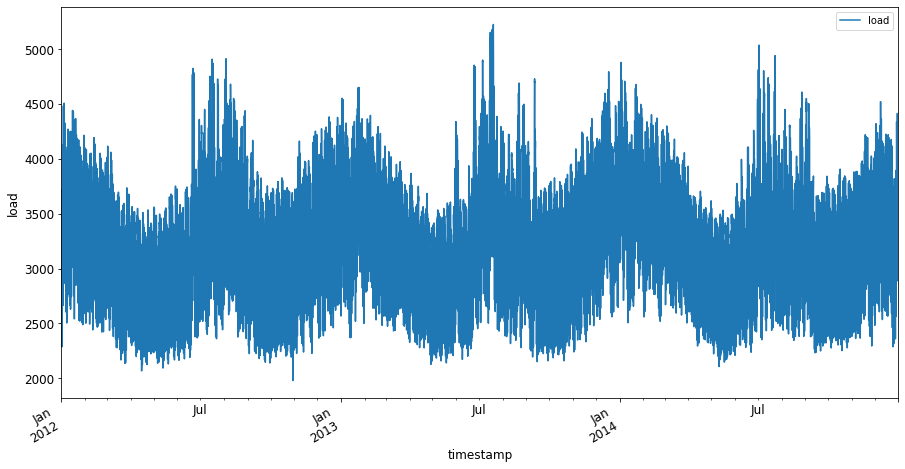

In [19]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Créer des ensembles de données d'entraînement et de test

### Introduction
Dans cette section, nous allons apprendre à diviser un ensemble de données en deux parties : un ensemble d'entraînement et un ensemble de test. Cette étape est essentielle pour évaluer les performances de votre modèle.

### Pourquoi diviser les données ?
La division des données permet de :
- Former le modèle sur un sous-ensemble des données (ensemble d'entraînement).
- Tester le modèle sur des données qu'il n'a jamais vues auparavant (ensemble de test), afin d'évaluer sa capacité à généraliser.

### Étapes pour créer les ensembles
1. **Charger les données** : Assurez-vous que vos données sont prêtes et correctement formatées.
2. **Diviser les données** : Utilisez une méthode appropriée pour séparer les données en deux ensembles.
3. **Vérifier les proportions** : Confirmez que les ensembles d'entraînement et de test sont représentatifs de l'ensemble de données initial.

### Exemple de code
Voici un exemple simple pour diviser un ensemble de données en Python :

```python
from sklearn.model_selection import train_test_split

# Charger les données
X, y = charger_donnees()

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))
```

### Bonnes pratiques
- **Fixer une graine aléatoire** : Utilisez `random_state` pour garantir la reproductibilité.
- **Choisir une proportion appropriée** : Une division courante est 80 % pour l'entraînement et 20 % pour le test.
- **Éviter les fuites de données** : Assurez-vous que les données de test ne contiennent aucune information utilisée pendant l'entraînement.

[!TIP] Si votre ensemble de données est déséquilibré, envisagez d'utiliser une division stratifiée pour préserver la distribution des classes.

### Conclusion
Diviser vos données est une étape cruciale dans le processus de création d'un modèle. Cela garantit que vous pouvez évaluer les performances de votre modèle de manière fiable et éviter les biais.


In [20]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

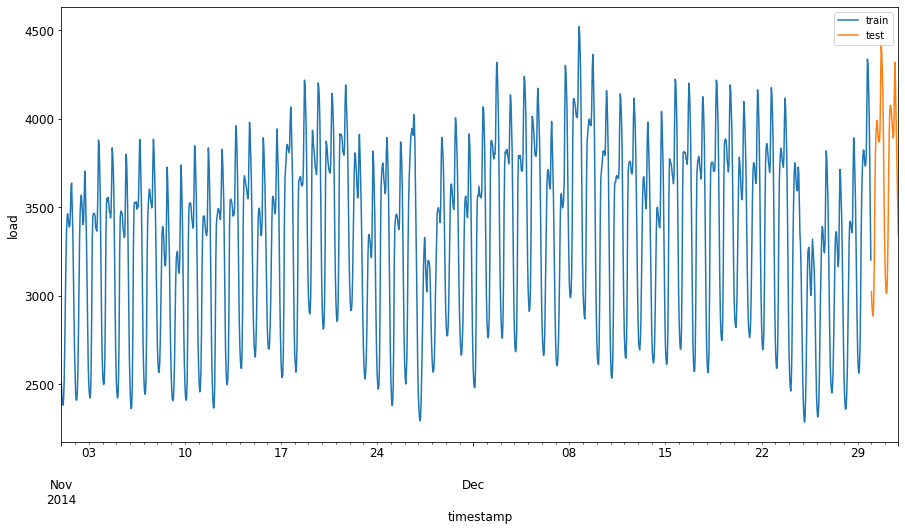

In [21]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [23]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

Données originales vs données mises à l'échelle :


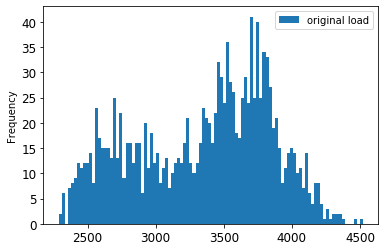

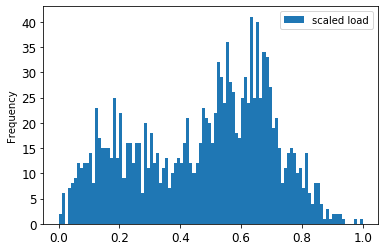

In [24]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Mettons également à l'échelle les données de test


In [25]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [27]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.239
Date:                            Thu, 30 Sep 2021   AIC                          -6942.477
Time:                                    14:36:28   BIC                          -6911.050
Sample:                                11-01-2014   HQIC                         -6930.725
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.226      0.000       0.809       0.872
ar.L2         -0.5220      0.034   

## Évaluer le modèle


Créez un point de données de test pour chaque étape HORIZON.


In [28]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

Faire des prédictions sur les données de test


In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

Comparer les prévisions à la charge réelle


In [30]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    3,008.74 3,023.00
1 2014-12-30 01:00:00  t+1    2,955.53 2,935.00
2 2014-12-30 02:00:00  t+1    2,900.17 2,899.00
3 2014-12-30 03:00:00  t+1    2,917.69 2,886.00
4 2014-12-30 04:00:00  t+1    2,946.99 2,963.00

Calculez **l'erreur absolue moyenne en pourcentage (MAPE)** pour toutes les prédictions

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$


In [31]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5570581332313952 %


In [33]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1460048657704118 %


Tracez les prédictions par rapport aux valeurs réelles pour la première semaine de l'ensemble de test


No handles with labels found to put in legend.


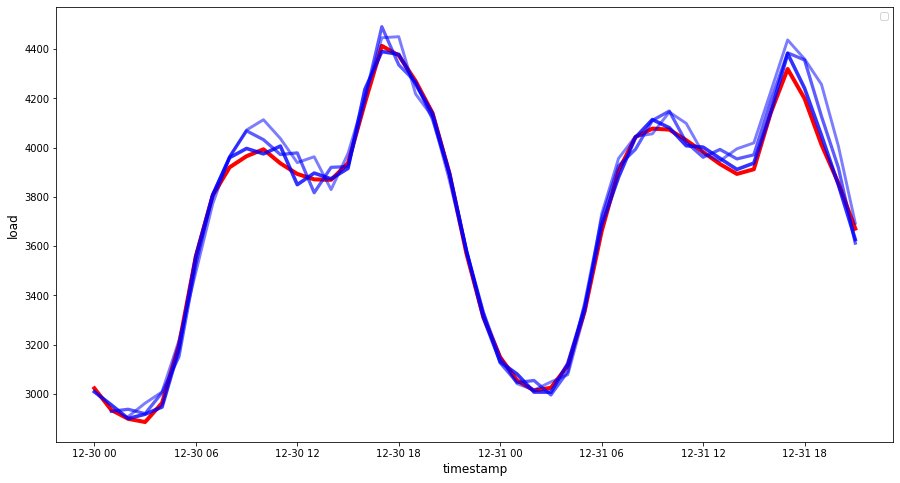

In [34]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


---

**Avertissement** :  
Ce document a été traduit à l'aide du service de traduction automatique [Co-op Translator](https://github.com/Azure/co-op-translator). Bien que nous nous efforcions d'assurer l'exactitude, veuillez noter que les traductions automatisées peuvent contenir des erreurs ou des inexactitudes. Le document original dans sa langue d'origine doit être considéré comme la source faisant autorité. Pour des informations critiques, il est recommandé de faire appel à une traduction humaine professionnelle. Nous déclinons toute responsabilité en cas de malentendus ou d'interprétations erronées résultant de l'utilisation de cette traduction.
